In [1]:
import yaml
from TraceSimulator import TraceSimulator
from trigger_clean import *
import numpy as np
import matplotlib.pyplot as plt

def read_yaml_to_dict(file_path):
    with open(file_path, 'r') as file:
        config_dict = yaml.safe_load(file)
    return config_dict

config = read_yaml_to_dict('config.yaml')
ts = TraceSimulator(config)

/home/dwong/anaconda3/lib/python3.12/site-packages/TraceSimulator/TraceSimulator.py:185: RuntimeWarning: overflow encountered in exp
  self.template = np.concatenate([(np.exp((xs - self.trigger_time) / self.tau_rise))[xs <= self.trigger_time], (np.exp(-(xs - self.trigger_time) / self.tau_decay))[xs > self.trigger_time]])


/home/dwong/anaconda3/lib/python3.12/site-packages/TraceSimulator/TraceSimulator.py:276: RuntimeWarning: invalid value encountered in divide
  E_ir_avg = E_ir / N_ir


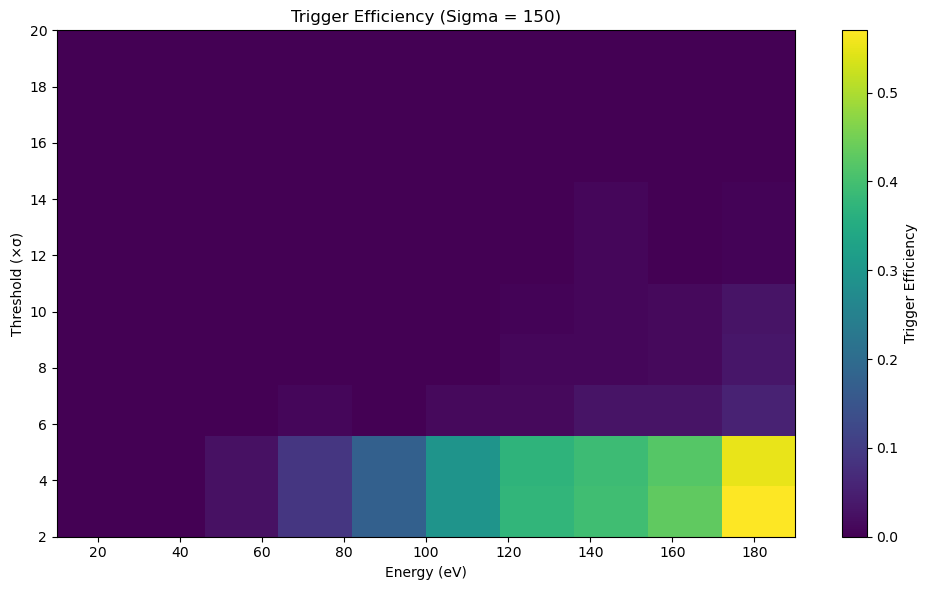

In [2]:
# Parameters
n_simulations = 200
sigma = 150  # fixed GDF kernel sigma
energies = np.arange(10, 201, 20)
thresholds = np.arange(2, 21, 2)  # in units of std deviation

# Initialize results array: rows = thresholds, cols = energies
triggered_counts = np.zeros((len(thresholds), len(energies)))

for j, energy in enumerate(energies):
    for _ in range(n_simulations):
        trace, _ = ts.generate(energy, type_recoil='NR')  # shape: (1, 54, N)
        trace = trace[0]  # (54, N)

        # Compute baseline std from pre-pulse region of first channel
        baseline_std = np.std(trace[0][:2048])

        for i, threshold_scale in enumerate(thresholds):
            threshold = threshold_scale * baseline_std

            # Check if any channel triggers
            any_triggered = any(
                gdf_trigger(trace[ch], sigma=sigma, threshold=threshold)
                for ch in range(trace.shape[0])
            )
            triggered_counts[i, j] += int(any_triggered)

# Normalize if you want efficiency instead of counts:
trigger_efficiency = triggered_counts / n_simulations

# Plot 2D heatmap
plt.figure(figsize=(10, 6))
plt.imshow(trigger_efficiency, aspect='auto', origin='lower',
           extent=[energies[0], energies[-1], thresholds[0], thresholds[-1]],
           interpolation='nearest')
plt.colorbar(label='Trigger Efficiency')
plt.xlabel('Energy (eV)')
plt.ylabel('Threshold (×σ)')
plt.title(f'Trigger Efficiency (Sigma = {sigma})')
plt.tight_layout()
plt.show()


